In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
sns.set_theme(style="white")

### stats analysis imports 
import statsmodels.formula.api as smf

SEED = 125

In [2]:
def print_df_info(df, name):
    print(f"{name}")
    print(f"shape: {df.shape}")
    print(f"columns: {df.columns}")
    print()

# 0. Loading and pre-processing data for regression

In [3]:
persuasive_strategies_df = pd.read_csv("llm_responses_labeled.csv", index_col=0)
treatment_df = pd.read_csv("final_data_processed.csv", index_col = 0)

In [4]:
print_df_info(treatment_df, "treatment_df")
print("Number of unique treatment messages: ", treatment_df['treatment_message_id'].nunique())
treatment_df.head()

treatment_df
shape: (25982, 14)
columns: Index(['age', 'education', 'gender', 'party_affiliation', 'ideo_affiliation',
       'political_knowledge', 'issue', 'issue_full', 'treatment_message_id',
       'treatment_message', 'condition', 'model', 'dv_response_mean',
       'treatment_message_word_count'],
      dtype='object')

Number of unique treatment messages:  730


,age,education,gender,party_affiliation,ideo_affiliation,political_knowledge,issue,issue_full,treatment_message_id,treatment_message,condition,model,dv_response_mean,treatment_message_word_count
0,25,4-year college,Male,Strong Republican,Moderately liberal,2,assisted suicide,The U.S. should allow terminally ill patients ...,allow_terminally_ill_suicide_pythia-410m_3,"""For the sake of all humanity, I hereby procla...",AI,pythia-410m,100.00,49.0
1,52,Graduate degree,Male,Independent,Ideologically neutral,3,worker_pensions,The U.S. should transition pension plans for p...,transition_public_worker_pension_private_gpt-4...,The future of public workers in the United Sta...,AI,gpt-4-0125-preview,50.75,210.0
2,51,Technical certification or trade school,Male,Strong Republican,Moderately conservative,0,veteran healthcare,The U.S. should increase privatization of vete...,increase_veterans_healthcare_privatization_pyt...,Privatizing veteran healthcare is essential fo...,AI,pythia-1.4b,40.00,190.0
3,24,4-year college,Female,Moderate Republican,Moderately conservative,2,affirmative_action,The U.S. should not allow the use of affirmati...,allow_affirmative_action_Llama-2-70b-hf_1,Affirmative action programs were initially int...,AI,Llama-2-70b-hf,63.75,241.0
4,40,Graduate degree,Male,Independent,Very liberal,1,foreign_aid,The U.S. should not decrease foreign aid spending,decrease_foreign_aid_spending_Llama-2-70b-hf_1,Foreign aid is a crucial aspect to maintain pe...,AI,Llama-2-70b-hf,85.25,304.0


In [5]:
# for every row in treatment_df, take the entry `treatment_message` and find a match for it in persuasive_strategies_df['response']. If a match is found, copy over the persuasive strategies columns to treatment_df. 
# If no match is found, fill the persuasive strategies columns with NaN. 
# After this operation, treatment_df should have the same number of rows, but with additional columns for persuasive strategies.
merged_df = treatment_df.merge(persuasive_strategies_df, left_on='treatment_message', right_on='response', how='left')

# Print out the `treatment_message` values that did not find a match.
unmatched_subset = merged_df[merged_df['central'].isna()] 
print("Unmatched entries:", unmatched_subset['treatment_message'].unique())

# It appears that all of the unmatched entries are due to missing treatment messages (these are folks who expressed their position without receiving a treatment -- either from human or AI).
# We can fill in the persuasive strategy columns with 0 for these rows, since they received no persuasive strategies.
roles_with_notreatment = merged_df['treatment_message'].isna()
new_cols = ['attractiveness',
       'authority', 'central', 'forewarning', 'gainframe', 'lossframe',
       'partisan', 'partisanship', 'peripheral', 'refutation', 'religion',
       'repetition']
merged_df.loc[roles_with_notreatment, new_cols] = 0
# However, we should make a separate indicator for no treatment too. 
merged_df['no_treatment'] = 0 
merged_df.loc[roles_with_notreatment, 'no_treatment'] = 1

print_df_info(merged_df, "merged_df")
merged_df.head()    

Unmatched entries: [nan]
merged_df
shape: (25982, 29)
columns: Index(['age', 'education', 'gender', 'party_affiliation', 'ideo_affiliation',
       'political_knowledge', 'issue', 'issue_full', 'treatment_message_id',
       'treatment_message', 'condition', 'model', 'dv_response_mean',
       'treatment_message_word_count', 'issue_stance_full', 'response',
       'attractiveness', 'authority', 'central', 'forewarning', 'gainframe',
       'lossframe', 'partisan', 'partisanship', 'peripheral', 'refutation',
       'religion', 'repetition', 'no_treatment'],
      dtype='object')



,age,education,gender,party_affiliation,ideo_affiliation,political_knowledge,issue,issue_full,treatment_message_id,treatment_message,...,forewarning,gainframe,lossframe,partisan,partisanship,peripheral,refutation,religion,repetition,no_treatment
0,25,4-year college,Male,Strong Republican,Moderately liberal,2,assisted suicide,The U.S. should allow terminally ill patients ...,allow_terminally_ill_suicide_pythia-410m_3,"""For the sake of all humanity, I hereby procla...",...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,52,Graduate degree,Male,Independent,Ideologically neutral,3,worker_pensions,The U.S. should transition pension plans for p...,transition_public_worker_pension_private_gpt-4...,The future of public workers in the United Sta...,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0
2,51,Technical certification or trade school,Male,Strong Republican,Moderately conservative,0,veteran healthcare,The U.S. should increase privatization of vete...,increase_veterans_healthcare_privatization_pyt...,Privatizing veteran healthcare is essential fo...,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0
3,24,4-year college,Female,Moderate Republican,Moderately conservative,2,affirmative_action,The U.S. should not allow the use of affirmati...,allow_affirmative_action_Llama-2-70b-hf_1,Affirmative action programs were initially int...,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0
4,40,Graduate degree,Male,Independent,Very liberal,1,foreign_aid,The U.S. should not decrease foreign aid spending,decrease_foreign_aid_spending_Llama-2-70b-hf_1,Foreign aid is a crucial aspect to maintain pe...,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0


# 1. Effect of Persuasion Techniques on Persuasiveness

In this section, we supplement the original experiment dataset with variables that correspond to popular theories of "persuasive techniques". In particular, we use the `classify.py` script to call on a language model to classify whether each persuasive text (e.g. `treatment_message`) contains a particular strategy (e.g. `central` refers to a message "using reasons/evidence"). 

Note that the original study measures "persuasiveness" by taking some aggregation of `dv_response_mean` which measures how "aligned" a participant is with the stated issue position AFTER the treatment, and subtracting that from the control. In our use here, we do NOT aggregate because we want to understand how demographic features and persuasive strategies may contribute to "alignment". Control groups are distingushied by a custom one-hot encoded variable of `no_treatment`. 

In [6]:
X  = merged_df.drop(columns=['issue', 'issue_full', 'issue_stance_full', 'treatment_message_id', 'treatment_message', 
                             'partisan', 
                             'condition', 'model', 'dv_response_mean', 'response'])
y = merged_df['dv_response_mean']
print("Number of features: ", X.shape[1])
print("Number of samples: ", X.shape[0])
print("Feature columns: ", X.columns)

Number of features:  19
Number of samples:  25982
Feature columns:  Index(['age', 'education', 'gender', 'party_affiliation', 'ideo_affiliation',
       'political_knowledge', 'treatment_message_word_count', 'attractiveness',
       'authority', 'central', 'forewarning', 'gainframe', 'lossframe',
       'partisanship', 'peripheral', 'refutation', 'religion', 'repetition',
       'no_treatment'],
      dtype='object')


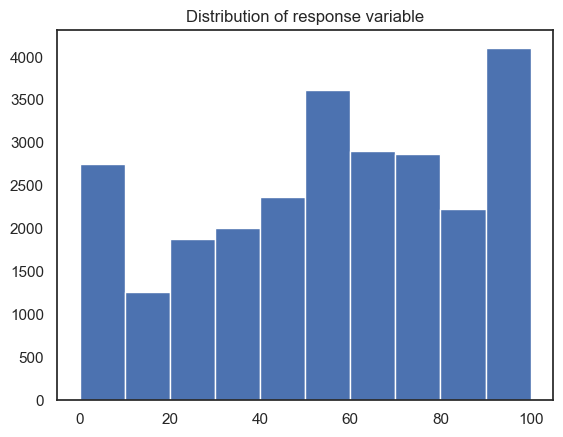

In [7]:
# what is the distribution of Y?
plt.hist(y)
plt.title("Distribution of response variable")
plt.show()

## 1.1 Naive regression on all covariates

In [8]:
import statsmodels.formula.api as smf

cols = list(merged_df.columns)
start_idx = cols.index("attractiveness")
cat_vars = cols[start_idx:]

formula = "dv_response_mean ~ age + C(education) + C(gender) + C(party_affiliation) + \
           C(ideo_affiliation) + political_knowledge + treatment_message_word_count + \
           " + " + ".join([f"C({c})" for c in cat_vars])

model = smf.ols(
    formula,
    data=merged_df
).fit(cov_type="HC3")   # robust SEs
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       dv_response_mean   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     14.12
Date:                Sat, 20 Sep 2025   Prob (F-statistic):           6.02e-77
Time:                        14:42:41   Log-Likelihood:                -99970.
No. Observations:               20819   AIC:                         2.000e+05
Df Residuals:                   20785   BIC:                         2.003e+05
Df Model:                          33                                         
Covariance Type:                  HC3                                         
                                                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

/Users/kaihung/miniconda3/envs/llm/lib/python3.13/site-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 34, but rank is 33
  warnings.warn('covariance of constraints does not have full '


## 1.2 One-Hot Encoded X + Correlation Heatmap

In [9]:
import patsy

# Use the exact formula string you built above
y, X = patsy.dmatrices(formula, data=merged_df, return_type="dataframe")

response = y.iloc[:, 0]         # dependent variable
X_expanded = X.drop(columns=["Intercept"], errors="ignore")  # predictors only
X_expanded.head()

,C(education)[T.4-year college],C(education)[T.Did not graduate high school],C(education)[T.Graduate degree],C(education)[T.High school diploma],C(education)[T.Technical certification or trade school],C(gender)[T.Male],C(gender)[T.Non-binary / third gender],C(gender)[T.Prefer not to say],C(party_affiliation)[T.Moderate Democrat],C(party_affiliation)[T.Moderate Republican],...,C(partisan)[T.1.0],C(partisanship)[T.1.0],C(peripheral)[T.1.0],C(refutation)[T.1.0],C(religion)[T.1.0],C(repetition)[T.1.0],C(no_treatment)[T.1],age,political_knowledge,treatment_message_word_count
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,2.0,49.0
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,3.0,210.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,51.0,0.0,190.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,24.0,2.0,241.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,40.0,1.0,304.0


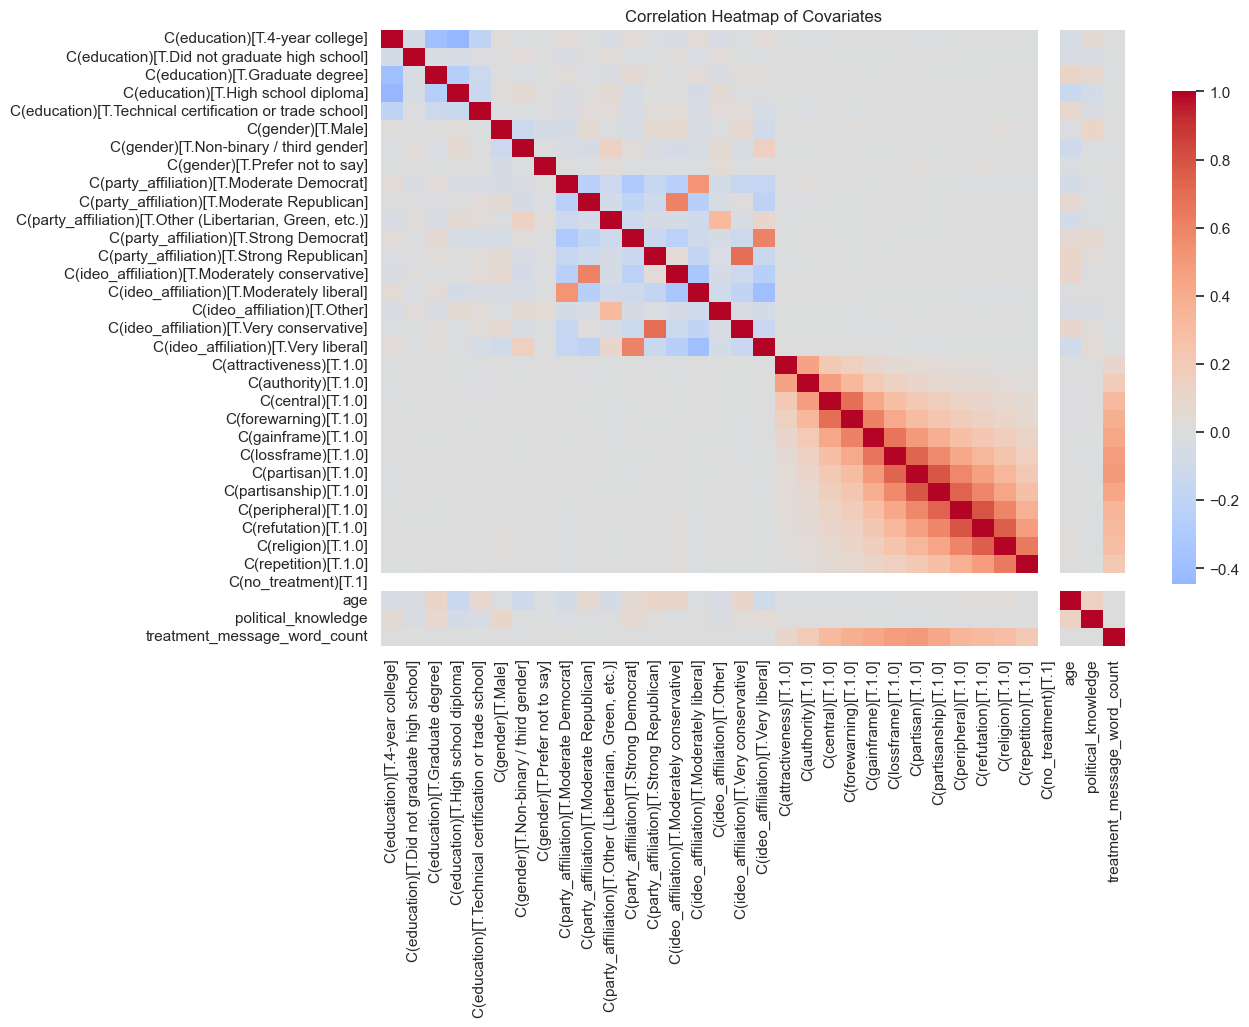

In [10]:
corr = X_expanded.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap="coolwarm", center=0, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap of Covariates")
plt.show()

## 1.3 Variance Inflation Factor (VIF) to detect collinear features! 

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_vif = X_expanded.assign(const=1) # add constant for VIF calculation

# Drop columns with perfect collinearity
X_vif_noint = X_vif.drop(columns=["const"], errors="ignore")
X_vif_noint = X_vif_noint.loc[:, X_vif_noint.std() > 0]  # drop constant/zero-variance cols


vif_data = pd.DataFrame({
    "variable": X_vif_noint.columns,
    "VIF": [variance_inflation_factor(X_vif_noint.values, i)
            for i in range(X_vif_noint.shape[1])]
})

vif_data.sort_values("VIF", ascending=False).head(15)


,variable,VIF
19,C(authority)[T.1.0],175.959349
18,C(attractiveness)[T.1.0],173.190295
20,C(central)[T.1.0],59.215300
21,C(forewarning)[T.1.0],33.905205
32,treatment_message_word_count,20.141388
22,C(gainframe)[T.1.0],13.796915
31,political_knowledge,11.781201
30,age,10.887840
23,C(lossframe)[T.1.0],9.347999
24,C(partisan)[T.1.0],8.153420


## 1.4 Model Selection with LASSO

In [12]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_expanded)

lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, response)

coef = pd.Series(lasso.coef_, index=X_expanded.columns)
selected = coef[coef != 0]

print("Best alpha (λ):", lasso.alpha_)
print("Selected variables:")
print(selected.sort_values())

Best alpha (λ): 0.07122185007995042
Selected variables:
C(ideo_affiliation)[T.Very liberal]                        -3.159087
C(ideo_affiliation)[T.Moderately liberal]                  -1.146300
C(partisanship)[T.1.0]                                     -1.130961
C(central)[T.1.0]                                          -1.012580
C(gender)[T.Male]                                          -0.865780
C(party_affiliation)[T.Other (Libertarian, Green, etc.)]   -0.537317
C(religion)[T.1.0]                                         -0.527396
C(gender)[T.Non-binary / third gender]                     -0.517375
C(education)[T.Graduate degree]                            -0.381788
C(partisan)[T.1.0]                                         -0.369880
C(education)[T.4-year college]                             -0.361763
C(gender)[T.Prefer not to say]                             -0.342964
C(ideo_affiliation)[T.Other]                               -0.240241
political_knowledge                            

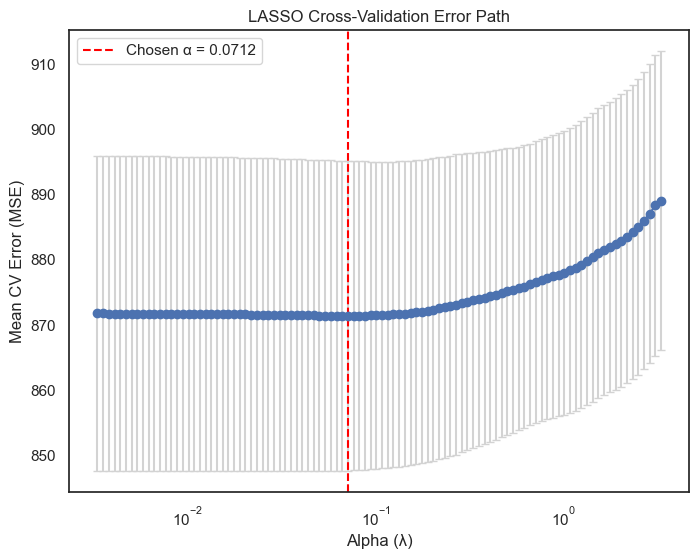

In [13]:
# LassoCV stores MSE values in lasso.mse_path_
# shape: (n_alphas, n_folds)
mse_mean = np.mean(lasso.mse_path_, axis=1)
mse_std = np.std(lasso.mse_path_, axis=1)

plt.figure(figsize=(8, 6))
plt.errorbar(lasso.alphas_, mse_mean, yerr=mse_std, fmt='o-', ecolor='lightgray', capsize=3)

plt.axvline(lasso.alpha_, color='red', linestyle='--', label=f"Chosen α = {lasso.alpha_:.4f}")
plt.xscale('log')
plt.xlabel("Alpha (λ)")
plt.ylabel("Mean CV Error (MSE)")
plt.title("LASSO Cross-Validation Error Path")
plt.legend()
plt.show()

In [17]:
import statsmodels.api as sm

# Restrict to selected predictors
X_post = X_expanded[selected.index]   # X_expanded is your patsy-expanded DataFrame
X_post = sm.add_constant(X_post)      # add intercept
y_post = response

post_lasso_model = sm.OLS(y_post, X_post).fit(cov_type="HC3")
print(f"Number of selected variables: {len(selected.index)}\n\n")
print(post_lasso_model.summary())

Number of selected variables: 28


                            OLS Regression Results                            
Dep. Variable:       dv_response_mean   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     16.60
Date:                Sat, 20 Sep 2025   Prob (F-statistic):           1.20e-79
Time:                        14:43:19   Log-Likelihood:                -99971.
No. Observations:               20819   AIC:                         2.000e+05
Df Residuals:                   20790   BIC:                         2.002e+05
Df Model:                          28                                         
Covariance Type:                  HC3                                         
                                                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

In [18]:
# Extract coefficients, p-values, and standard errors
results_df = pd.DataFrame({
    "coef": post_lasso_model.params,
    "pval": post_lasso_model.pvalues,
    "se": post_lasso_model.bse
})

# Filter by p-value < 0.10 (ignore intercept)
filtered = results_df.loc[results_df.index != "const"]
filtered = filtered[filtered["pval"] < 0.10]

# Sort by absolute coefficient magnitude
filtered_sorted = filtered.reindex(filtered["coef"].abs().sort_values(ascending=False).index)

print("Significant variables (p < 0.10), sorted by effect size:\n")
print(filtered_sorted)


Significant variables (p < 0.10), sorted by effect size:

                                                         coef          pval  \
C(authority)[T.1.0]                                 10.414219  5.152608e-05   
C(ideo_affiliation)[T.Very liberal]                 -7.742084  1.423297e-30   
C(gender)[T.Prefer not to say]                      -6.668086  5.759377e-02   
C(central)[T.1.0]                                   -6.396192  6.999244e-06   
C(peripheral)[T.1.0]                                 4.087058  3.860266e-08   
C(gender)[T.Non-binary / third gender]              -3.795356  2.143040e-02   
C(ideo_affiliation)[T.Moderately liberal]           -2.815022  3.320428e-06   
C(partisanship)[T.1.0]                              -2.811302  3.929795e-04   
C(party_affiliation)[T.Other (Libertarian, Gree...  -2.806551  2.221226e-02   
C(religion)[T.1.0]                                  -2.233624  4.812721e-03   
C(gender)[T.Male]                                   -1.928608  5.560161e-

# 2. Embedding-based Analysis

From the previous section, it is evident that the linear fit based on these one-hot encoded variables led to a very poor linear fit (e.g. R^2 ~= 0.02!) So, now we wonder if we can include more complex information about `treatment_text` using word embedding models. 